# LDCT Inv model

## Testing the implementation

In [1]:
from ldctinv.vae.blocks import ActNorm, GBlock, SelfAttention, SpectralNorm, DenseEncoderLayer
import torch.nn.functional as F
from torch.nn import BatchNorm2d
import torch.nn as nn
import torch
import math
from torchvision import models
from ldctinv.utils.distributions import DiagonalGaussianDistribution

class Generator(nn.Module):
    def __init__(
        self,
        code_dim,
        z_dim,
        im_ch,
        n_class,
        chn,
        use_actnorm,
        cond_ch,
        output_size=128,
        latimage=False,
    ):
        super().__init__()

        self.latimage = latimage
        self.z_dim = z_dim
        self.output_size = output_size
        if not latimage:
            self.num_layers = int(math.log2(output_size)) - 2
        else:
            self.num_layers = 5 # number of downsampling layers in ResNet50
        self.init_side_length = self.output_size // (2**(self.num_layers-latimage))
        if latimage and z_dim % (self.init_side_length)**2 != 0:
            raise ValueError(f"z_dim must be divisible by latent resolution**2 {(self.init_side_length**2)} when latimage=True")

        
        self.sa_id = self.num_layers - 2
        self.num_split = self.num_layers + 1
        self.linear = nn.Linear(n_class, 2*(self.init_side_length**2), bias=False)

        if self.latimage:
            split_size = 1
            self.first_view = z_dim // (self.init_side_length**2) - (self.num_split - 1) * split_size
            first_split = self.first_view
        else:
            split_size = 20
            self.first_view = (output_size // 8) ** 2 * chn
            first_split = z_dim - (self.num_split - 1) * split_size
            self.G_linear = SpectralNorm(nn.Linear(first_split, self.first_view))

        self.split_at = [first_split] + [split_size for _ in range(self.num_split - 1)]

        G_block_z_dim = 3 if self.latimage else code_dim + 28
        first_chn = (
            first_split
            if self.latimage
            else self.first_view // (self.output_size // (2**self.num_layers)) ** 2
        )

        channels = [first_chn] + [
            chn * (2**i) for i in range(self.num_layers - 1, -1, -1)
        ]
        print(channels)
        self.GBlock = nn.ModuleList(
            [
                GBlock(
                    channels[i] + cond_ch,
                    channels[i + 1],
                    n_class=n_class,
                    z_dim=G_block_z_dim,
                    upsample=(not self.latimage) or i > 0,
                    latimage=self.latimage,
                )
                for i in range(self.num_layers)
            ]
        )

        self.attention = SelfAttention(channels[self.sa_id])
        self.ScaledCrossReplicaBN = (
            BatchNorm2d(channels[-1], eps=1e-4)
            if not use_actnorm
            else ActNorm(channels[-1])
        )
        self.colorize = nn.Conv2d(
            channels[-1] + cond_ch, im_ch, kernel_size=3, padding=1
        )

    def forward(self, input, class_id, im_cond=None):

        if self.latimage:
            input = input.view(-1, self.z_dim // (self.init_side_length**2), self.init_side_length, self.init_side_length)
            
        codes = torch.split(input, self.split_at, 1)
        class_emb = self.linear(class_id)

        if not self.latimage:
            out = self.G_linear(codes[0])
            out = out.view(
                -1, self.init_side_length, self.init_side_length, self.first_view // (self.init_side_length**2)
            ).permute(0, 3, 1, 2)
        else:
            class_emb = class_emb.view(-1, 2, self.init_side_length, self.init_side_length)
            out = codes[0]

        for i, (code, GBlock) in enumerate(zip(codes[1:], self.GBlock)):
            if i == self.sa_id:
                out = self.attention(out)
            condition = torch.cat([code, class_emb], 1)
            if i > 1 and self.latimage:
                condition = F.interpolate(condition, scale_factor=2 ** (i - 1))
            if im_cond is not None:
                scale_factor = 1 / 2 ** (self.num_layers - i)
                if self.latimage and i==0:
                    scale_factor = 1 / 2 ** (self.num_layers - i - 1)
                im_cond_rescaled = F.interpolate(im_cond, scale_factor=scale_factor)
                out = torch.cat([out, im_cond_rescaled], 1)
            out = GBlock(out, condition)

        out = self.ScaledCrossReplicaBN(out)
        if im_cond is not None:
            out = torch.cat([out, im_cond], 1)
        out = self.colorize(out)
        return out

    def encode(self, *args, **kwargs):
        raise RuntimeError("BigGAN architecture does not have an encoder")

    def decode(self, z, cls):
        z = z.float()
        cls_one_hot = torch.nn.functional.one_hot(cls, num_classes=1000).float()
        return self.forward(z, cls_one_hot)

_norm_options = {"in": nn.InstanceNorm2d, "bn": nn.BatchNorm2d, "an": ActNorm}

class ResnetEncoder(nn.Module):
    def __init__(self, in_ch, z_dim, input_size, norm, net_type="resnet50", pretrained=False, latimage=False):
        super().__init__()
        self.latimage = latimage
        __possible_resnets = {
            "resnet18": models.resnet18,
            "resnet34": models.resnet34,
            "resnet50": models.resnet50,
            "resnet101": models.resnet101,
        }
        __possible_weights = {
            "resnet18": models.ResNet18_Weights.IMAGENET1K_V1,
            "resnet34": models.ResNet34_Weights.IMAGENET1K_V1,
            "resnet50": models.ResNet50_Weights.IMAGENET1K_V1,
            "resnet101": models.ResNet101_Weights.IMAGENET1K_V1,
        }
        z_dim = self.z_dim = z_dim
        ipt_size = input_size
        self.input_size = [in_ch, ipt_size, ipt_size]
        norm_layer = _norm_options[norm]
        self.z_dim = z_dim
        if pretrained and norm != "bn":
            warnings.warn(
                f"If pretrained, then args.norm must be bn! Got pretrained={pretrained} but norm_layer={norm}. Using bn for ResNet instead!"
            )
            norm_layer = _norm_options["bn"]
        self.model = __possible_resnets[net_type](
            weights=__possible_weights[net_type] if pretrained else None, norm_layer=norm_layer
        )

        # replace first conv
        self.model.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #self.model.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3, stride=2, padding=1, bias=False)
        #self.model.maxpool_n = nn.MaxPool2d(kernel_size=8)

        size_pre_fc = self._get_spatial_size()
        assert size_pre_fc[2] == size_pre_fc[3], "Output spatial size is not quadratic"
        spatial_size = size_pre_fc[2]
        num_channels_pre_fc = size_pre_fc[1]
        print("spatial size: ", spatial_size)
        print("num_channels_pre_fc: ", num_channels_pre_fc)

        if not self.latimage:
            # replace last fc
            self.model.fc = DenseEncoderLayer(
                0, spatial_size=spatial_size, out_size=2 * z_dim, in_channels=num_channels_pre_fc
            )
        else:
            assert z_dim%(spatial_size**2)==0, f"z_dim has to be a multiple of {spatial_size**2}"
            self.model.mu_layer = nn.Conv2d(num_channels_pre_fc, z_dim//(spatial_size**2), kernel_size=1)
            #self.model.logvar_layer = nn.Conv2d(num_channels_pre_fc, z_dim//(spatial_size**2), kernel_size=1)
            self.model.flatten = nn.Flatten()

    def forward(self, x):
        #x[:,0] = x[:,0] - x[:,1]
        features = self.features(x)
        encoding = self.post_features(features)

        return encoding

    def features(self, x):
        x = self.model.conv1(x)
        #x_n = self.model.maxpool_n(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        #if self.latimage:
        #    x = torch.cat([x,x_n], dim=1)
        if not self.latimage:
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
        return x

    def post_features(self, x):
        if not self.latimage:
            x = self.model.fc(x)
        else:
            mu = self.model.mu_layer(x)
            #logvar = self.model.logvar_layer(x)
            logvar = torch.zeros_like(mu)
            x = torch.cat((self.model.flatten(mu), self.model.flatten(logvar)), dim=1).unsqueeze(-1).unsqueeze(-1)
        return x

    def _get_spatial_size(self):
        x = torch.randn(1, *self.input_size)
        return self.features(x).size()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
g = Generator(code_dim=120, z_dim=49*64, im_ch=1, n_class=1000, chn=96, use_actnorm=True, cond_ch=1, output_size=224, latimage=True).to(device)

[11, 1536, 768, 384, 192, 96]


In [5]:
x_in = torch.randn(5, 49*64).to(device)
class_in = torch.randn(5, 1000).to(device)
im_cond = torch.randn(5, 1, 224, 224).to(device)
out = g(x_in, class_in, im_cond=im_cond)
print(out.shape)

torch.Size([5, 1, 224, 224])


In [6]:
r = ResnetEncoder(in_ch=2, z_dim=49*64, input_size=224, norm="bn", net_type="resnet50", pretrained=True, latimage=True).to(device)

spatial size:  14
num_channels_pre_fc:  1024


In [7]:
im_in = torch.randn(5, 1, 224, 224).to(device)
im_cond = torch.randn(5, 1, 224, 224).to(device)
with torch.no_grad():
    out = r(torch.cat((im_in, im_cond), dim=1))
    print("mu + logvar shape:", out.shape)
    z = DiagonalGaussianDistribution(out, deterministic=False).sample()
    print("z shape: ", z.shape)
    rec = g(z, class_in, im_cond=im_cond)
    print("rec shape: ", rec.shape)

mu + logvar shape: torch.Size([5, 6272, 1, 1])
z shape:  torch.Size([5, 3136, 1, 1])
rec shape:  torch.Size([5, 1, 224, 224])


## Model plotting

In [20]:
from fff import FiberModel
import os
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"

model_folder = "/home/armand/helix_store/fiberlearning/lightning_logs/version_317/"
# model_folder = "/home/armand/PhD/FFF_fiberlearning/lightning_logs/version_4/"

hparams_path = os.path.join(model_folder, "hparams.yaml")
checkpoint_path = os.path.join(model_folder, "checkpoints/last.ckpt")
# checkpoint_path = os.path.join(model_folder, "checkpoints/epoch=5-step=144.ckpt")

ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
hparams = ckpt["hyper_parameters"]
hparams["data_set"]["root"] = "/mnt/SSD_2TB/ldct_data"
hparams["data_set"]["subject_model_path"] = "../notebooks/SubjectModels/saved_models/BiomedClip.pt"
# if hparams.get("load_lossless_ae_path") is None and "LDCTInvModel" in hparams["lossless_ae"]["model_spec"][0]['name']:
#     hparams["lossless_ae"]["model_spec"][0]['latent_dim'] //= 2
if hparams["lossless_ae"].get("cond_embedding_network") is not None:
    hparams["lossless_ae"]["cond_embedding_network"][1]["normalize"] = True
hparams["load_lossless_ae_path"] = None # "/home/armand/helix_store/fiberlearning/lightning_logs/version_264/checkpoints/last.ckpt"
hparams["ae_deterministic_encode"] = False
hparams["data_set"]["augment"] = True



model = FiberModel(hparams)
model.load_state_dict(ckpt["state_dict"])
model.eval()
model.to(device)
pass

/tmp/ipykernel_40701/2915963302.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU


loading subject_model
spatial size:  14
num_channels_pre_fc:  1024


  0%|          | 0/100 [00:00<?, ?it/s]

Loss before refinement: 0.021028993651270866, after refinement: 0.0023563173599541187


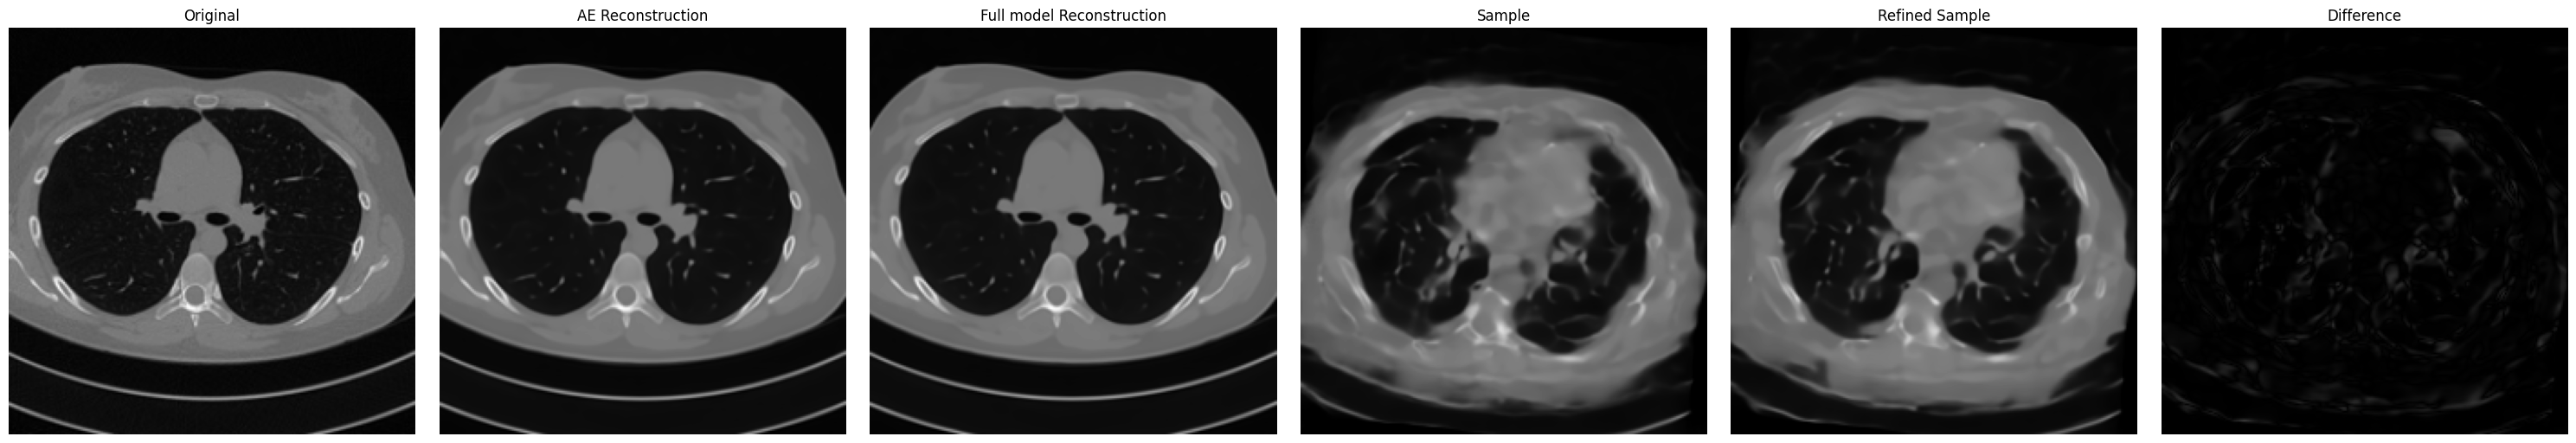

In [21]:
import matplotlib.pyplot as plt
import torch
from math import prod
from tqdm.auto import tqdm, trange

device = "cuda" if torch.cuda.is_available() else "cpu"
n_samples = 1
n_plots = 3+3*n_samples

@torch.no_grad()
def sample_with_latent_contraction(model, sample_shape, condition=None, scaling_factor=1.0, **kwargs):
    try:
        z_dense = model.get_latent(model.device).sample(sample_shape, condition)
    except TypeError:
        z_dense = model.get_latent(model.device).sample(sample_shape)
    z_dense = z_dense.reshape(
        prod(sample_shape), *z_dense.shape[len(sample_shape) :]
    ) * scaling_factor
    batch = [z_dense]
    if condition is not None:
        c = condition
    else:
        c = torch.empty(z_dense.shape[0], 0).to(z_dense.device)
    z = model.sample_density(z_dense, c, **kwargs)
    x = model.decode_lossless(z, c)
    return x.reshape(sample_shape + x.shape[1:])

@torch.enable_grad()
def refine_with_gradient_descent(samples, originals, conditions, model, steps=25, lr=0.01):
    subject_model = model.subject_model
    samples = samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([samples], lr=lr)
    original_embeddings = subject_model.encode(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    subject_model.eval()
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        loss = criterion(subject_model.encode(samples), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return samples.detach()

@torch.enable_grad()
def refine_in_ae_latent_space(samples, originals, conditions, model, steps=25, lr=0.01):
    with torch.no_grad():
        z_samples = model.encode_lossless(samples.to(device), conditions).detach()
    z_samples = z_samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([z_samples], lr=lr)
    original_embeddings = model.subject_model.encode(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        decoded = model.decode_lossless(z_samples, conditions)
        loss = criterion(model.subject_model.encode(decoded), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return model.decode_lossless(z_samples, conditions).detach().reshape(samples.shape)

with torch.no_grad():
    batch = model.val_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0 = conditioned.x0.to(device)

    x_rec_ae = model.decode_lossless(model.encode_lossless(x0, c, return_only_x=True), c)
    x_rec_ae = x_rec_ae.squeeze(0).reshape(1, resolution, resolution)

    if not model.density_model_type in ["diffusion"]:
        x_rec = model(x0, c)
        x_rec = x_rec.squeeze(0).reshape(1, resolution, resolution)
    else:
        x_rec = x_rec_ae
        
    if model.hparams.cfg:
        samples = model.sample(torch.Size([n_samples]), 
                               condition=c.repeat(n_samples, 1), 
                               guidance_scale=2.0).reshape(n_samples, 1, resolution, resolution)
    else:
        samples = sample_with_latent_contraction(model, 
                                                 torch.Size([n_samples]), 
                                                 condition=c.repeat(n_samples, 1), 
                                                 scaling_factor=1.0).reshape(n_samples, 1, resolution, resolution)
    refined_samples = refine_in_ae_latent_space(samples, 
                                                   x0,
                                                   c,
                                                   model, 
                                                   steps=100, lr=0.02)
    plt.figure(figsize=(n_plots*5, 5))
    plt.subplot(1, n_plots, 1)
    # save color range:
    vmin = x0.min().item()
    vmax = x0.max().item()
    plt.imshow(x0.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, n_plots, 2)
    plt.imshow(x_rec_ae.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title("AE Reconstruction")
    plt.subplot(1, n_plots, 3)
    plt.imshow(x_rec.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title("Full model Reconstruction")
    for i in range(n_samples):
        plt.subplot(1, n_plots, 4+i*3)
        plt.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
        plt.title("Sample")
        plt.subplot(1, n_plots, 4+i*3+1)
        plt.imshow(refined_samples[i].squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
        plt.title("Refined Sample")
        plt.subplot(1, n_plots, 4+i*3+2)
        plt.imshow(torch.abs(samples[i] - refined_samples[i]).squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=(vmax-vmin))
        plt.axis("off")
        plt.title("Difference")
    plt.tight_layout()
    plt.show()

In [15]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_latent(model, data_loader, max_batches=10):
    latent_ae = []
    latent = []
    latent_ae_sampled = []
    
    for i, batch in enumerate(data_loader):
        if i >= max_batches:
            break
        batch = (batch[0].to(device), batch[1].to(device))
        conditioned = model.apply_conditions(batch)
        c = conditioned.condition.to(device)
        x0 = conditioned.x0.to(device)
        z_ae = model.encode_lossless(x0, c, return_only_x=True)
        if model.density_model_type in ["diffusion"]:
            z = torch.randn_like(z_ae)
        else:
            z = model.encode_density(z_ae, c)
            # z_ae_recon = model.decode_density(z, c)
            # recon_error = torch.sqrt(torch.mean((z_ae - z_ae_recon)**2, dim=1))
        z_ae = z_ae.view(z_ae.shape[0], -1)
        z = z.view(z.shape[0], -1)
        z_sampled = model.sample_density(torch.randn_like(z), c)
        latent_ae.append(z_ae)
        latent.append(z)
        latent_ae_sampled.append(z_sampled)
    latent_ae = torch.cat(latent_ae, dim=0)
    latent = torch.cat(latent, dim=0)
    latent_ae_sampled = torch.cat(latent_ae_sampled, dim=0)
    plt.figure(figsize=(12, 15))
    plt.subplot(3, 3, 1)
    # plot reference gaussian
    x = torch.linspace(-3, 3, 100)
    y = torch.linspace(-3, 3, 100)
    X, Y = torch.meshgrid(x, y)
    Z = torch.exp(-X**2 - Y**2)
    plt.scatter(latent_ae[:, 0].cpu().numpy(), latent_ae[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Latent AE, first two coords")
    plt.subplot(3, 3, 2)
    plt.scatter(latent[:, 0].cpu().numpy(), latent[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Latent density, first two coords")
    plt.subplot(3, 3, 3)
    plt.scatter(latent_ae_sampled[:, 0].cpu().numpy(), latent_ae_sampled[:, 1].cpu().numpy(), s=1)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.contour(X, Y, Z, levels=10, colors="red", alpha=0.3)
    plt.title("Sampled AE latent, first two coords")
    plt.subplot(3, 3, 4)
    latent_ae_mean = latent_ae.mean(dim=0)
    plt.hist(latent_ae_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Latent AE mean")
    plt.subplot(3, 3, 5)
    latent_mean = latent.mean(dim=0)
    plt.hist(latent_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Latent density mean")
    plt.subplot(3, 3, 6)
    latent_mean = latent_ae_sampled.mean(dim=0)
    plt.hist(latent_mean.cpu().numpy(), range=[-2, 2], bins=50)
    plt.title("Sampled AE latent mean")
    plt.subplot(3, 3, 7)
    latent_ae_std = latent_ae.std(dim=0)
    plt.hist(latent_ae_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Latent AE std")
    plt.subplot(3, 3, 8)
    latent_std = latent.std(dim=0)
    plt.hist(latent_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Latent density std")
    plt.subplot(3, 3, 9)
    latent_std = latent_ae_sampled.std(dim=0)
    plt.hist(latent_std.cpu().numpy(), range=[0, 5], bins=50)
    plt.title("Sampled AE latent std")
    plt.show()
    plt.close()

/home/armand/miniconda3/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


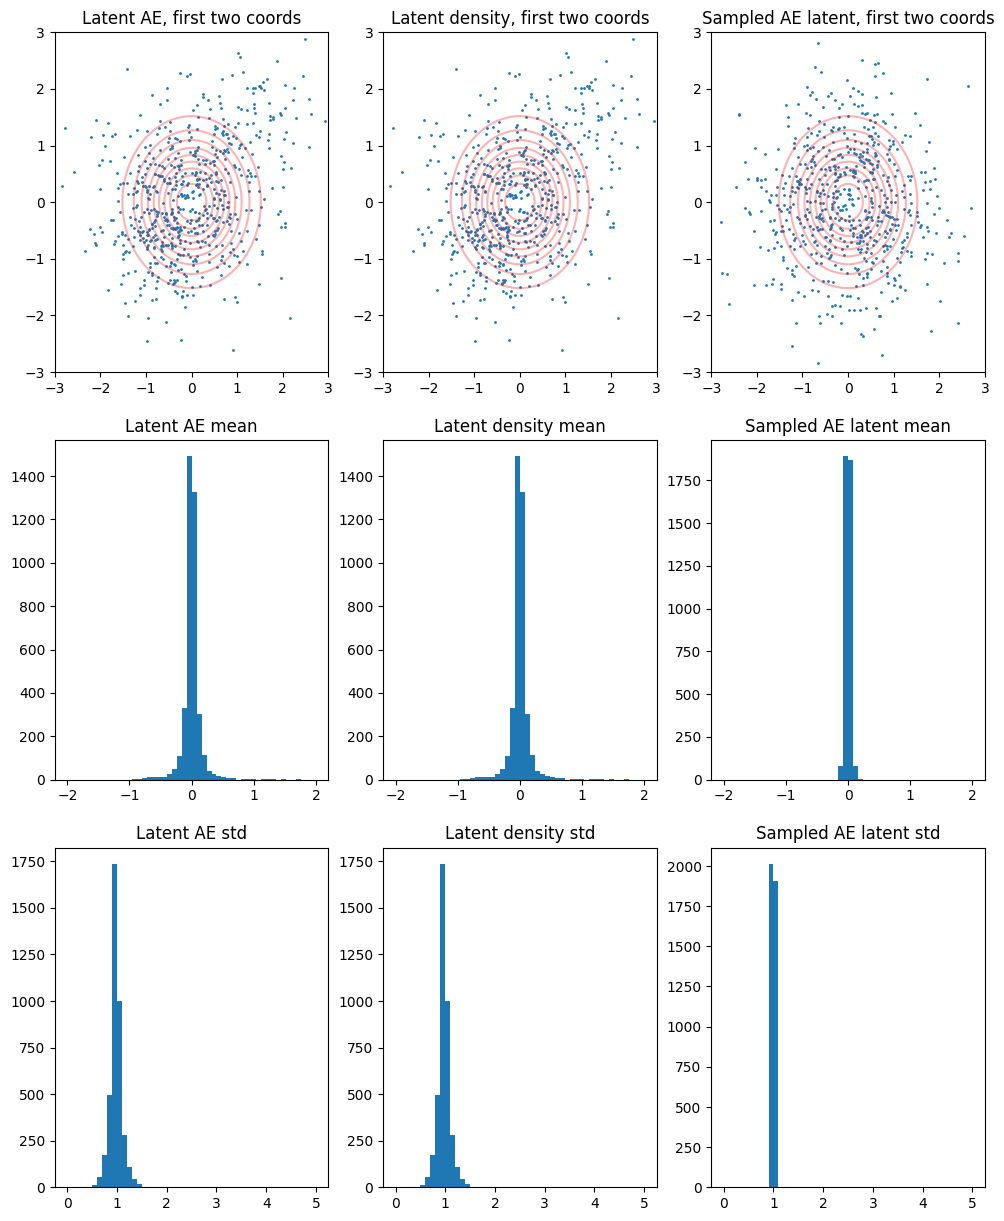

In [16]:
plot_latent(model, model.train_dataloader(), max_batches=10)

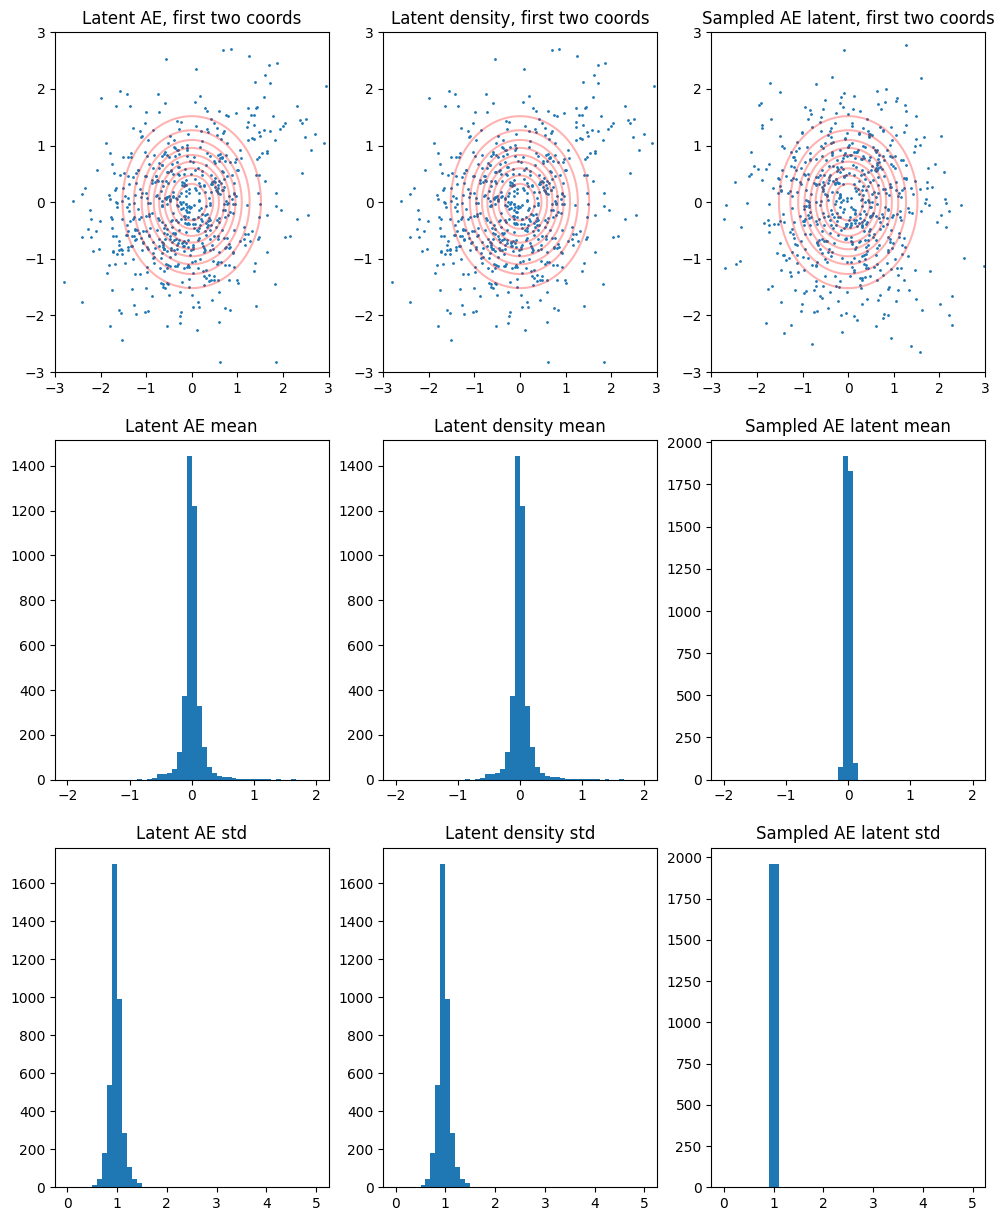

In [17]:
plot_latent(model, model.val_dataloader(), max_batches=10)

In [3]:
from fff.data import load_dataset
data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": False,
    "data_norm":"meanstd",
}
_, val_ds, _ = load_dataset(**data_set_config)
test_image = val_ds[0][0].unsqueeze(0).to(device).reshape(1, 1, 224, 224)
with torch.no_grad():
    test_image_embedding = model.subject_model.encode(test_image) # Apply the degredation model

print(f"First 5 dimensions of BiomedClip embeddings: {test_image_embedding.squeeze()[:5]}")


First 5 dimensions of BiomedClip embeddings: tensor([ 2.3668e-02, -1.3415e-02, -2.6287e-01, -4.5011e-02,  5.0259e-05],
       device='cuda:0')


In [9]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

@torch.no_grad()
def get_fiber_loss(model, orig, fake):
    return torch.sqrt(torch.mean((model.subject_model.encode(orig) - model.subject_model.encode(fake))**2))

@torch.no_grad()
def fiber_loss_with_guidance(model, data_loader, max_batches=10, scales=[1.0, 1.5, 2.0, 3.0, 5.0]):
    fiber_losses = []
    fiber_losses_refined = []
    n_batches = min(max_batches, len(data_loader))
    all_samples = []
    all_refined_samples = []
    all_originals = []
    
    for i, scale in enumerate(tqdm(scales, position=0)):
        fiber_losses.append(0.0)
        fiber_losses_refined.append(0.0)
        originals = []
        samples_combined = []
        refined_samples_combined = []
        for k, batch in enumerate(tqdm(data_loader, position=1, leave=False, total=n_batches)):
            if k >= max_batches:
                break
            batch = (batch[0].to(device), batch[1].to(device))
            conditioned = model.apply_conditions(batch)
            c = conditioned.condition.to(device)
            x0 = conditioned.x0.to(device)
            originals.append(x0)
            samples = model.sample(torch.Size([x0.shape[0]]), condition=c, guidance_scale=scale).reshape(x0.shape[0], 1, resolution, resolution)
            samples_combined.append(samples)
            fiber_losses[i] += get_fiber_loss(model, x0, samples)
            n_sub_batches = len(torch.split(samples, 8, dim=0))
            for sub_batch in zip(torch.split(samples, 8, dim=0), torch.split(x0, 8, dim=0), torch.split(c, 8, dim=0)):
                refined_samples = refine_in_ae_latent_space(sub_batch[0], sub_batch[1], sub_batch[2], model, steps=50, lr=0.02)
                refined_samples_combined.append(refined_samples)
                fiber_losses_refined[i] += get_fiber_loss(model, sub_batch[1], refined_samples)
        fiber_losses[i] /= n_batches
        fiber_losses_refined[i] /= n_batches * n_sub_batches
        originals = torch.cat(originals, dim=0)
        samples_combined = torch.cat(samples_combined, dim=0)
        refined_samples_combined = torch.cat(refined_samples_combined, dim=0)
        all_originals.append(originals)
        all_samples.append(samples_combined)
        all_refined_samples.append(refined_samples_combined)
    return scales, fiber_losses, fiber_losses_refined, all_originals, all_samples, all_refined_samples

@torch.no_grad()
def fiber_loss_without_guidance(model, data_loader, max_batches=10):
    n_batches = min(max_batches, len(data_loader))
    originals = []
    samples_combined = []
    refined_samples_combined = []
    fiber_loss = 0.0
    fiber_loss_refined = 0.0
    for k, batch in enumerate(tqdm(data_loader, position=0, leave=True, total=n_batches)):
        if k >= max_batches:
            break
        batch = (batch[0].to(device), batch[1].to(device))
        conditioned = model.apply_conditions(batch)
        c = conditioned.condition.to(device)
        x0 = conditioned.x0.to(device)
        originals.append(x0)
        samples = model.sample(torch.Size([x0.shape[0]]), condition=c).reshape(x0.shape[0], 1, resolution, resolution)
        samples_combined.append(samples)
        fiber_loss += get_fiber_loss(model, x0, samples)
        n_sub_batches = len(torch.split(samples, 8, dim=0))
        for sub_batch in zip(torch.split(samples, 8, dim=0), torch.split(x0, 8, dim=0), torch.split(c, 8, dim=0)):
            refined_samples = refine_in_ae_latent_space(sub_batch[0], sub_batch[1], sub_batch[2], model, steps=50, lr=0.02)
            refined_samples_combined.append(refined_samples)
            fiber_loss_refined += get_fiber_loss(model, sub_batch[1], refined_samples)
    fiber_loss /= n_batches
    fiber_loss_refined /= n_batches*n_sub_batches

    samples_combined = torch.cat(samples_combined, dim=0)
    refined_samples_combined = torch.cat(refined_samples_combined, dim=0)
    originals = torch.cat(originals, dim=0)
    return fiber_loss, fiber_loss_refined, originals, samples_combined, refined_samples_combined

In [10]:
fiber_loss_fm_no_guidance = fiber_loss_without_guidance(model, model.val_dataloader(), max_batches=8)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015849392861127853, after refinement: 0.0032615968957543373


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015810860320925713, after refinement: 0.0029205316677689552


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016269197687506676, after refinement: 0.003695589955896139


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017882518470287323, after refinement: 0.0037402468733489513


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015132464468479156, after refinement: 0.003285709535703063


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016881905496120453, after refinement: 0.0038404297083616257


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.020706579089164734, after refinement: 0.003956185188144445


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014587270095944405, after refinement: 0.00281669944524765


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014457601122558117, after refinement: 0.0032057787757366896


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015975389629602432, after refinement: 0.003703551134094596


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019793052226305008, after refinement: 0.004754998721182346


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017621535807847977, after refinement: 0.0038954427000135183


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01759977638721466, after refinement: 0.0037063774652779102


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018032347783446312, after refinement: 0.004562593065202236


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018413661047816277, after refinement: 0.003957728389650583


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015167810022830963, after refinement: 0.003363944124430418


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01769116520881653, after refinement: 0.0037237161304801702


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014084774069488049, after refinement: 0.0027918503619730473


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01623532362282276, after refinement: 0.0032641657162457705


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016384238377213478, after refinement: 0.003361115697771311


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015492130070924759, after refinement: 0.002920557511970401


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016809025779366493, after refinement: 0.003388641169294715


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01742413640022278, after refinement: 0.0037745884619653225


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016478916630148888, after refinement: 0.0036012909840792418


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01635162904858589, after refinement: 0.0039812782779335976


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017341820523142815, after refinement: 0.0037330416962504387


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015196863561868668, after refinement: 0.0032441201619803905


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017013510689139366, after refinement: 0.0033182098995894194


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.02153494395315647, after refinement: 0.004421933088451624


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.0165435541421175, after refinement: 0.0033385546412318945


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01671936735510826, after refinement: 0.0034111381974071264


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01704922877252102, after refinement: 0.0036107979249209166


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.013911319896578789, after refinement: 0.002889561001211405


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015659870579838753, after refinement: 0.0031259602401405573


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01490882970392704, after refinement: 0.0032778673339635134


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017832059413194656, after refinement: 0.00327542657032609


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01860872283577919, after refinement: 0.004002543166279793


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01576552353799343, after refinement: 0.0034435836132615805


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017431041225790977, after refinement: 0.0034551455173641443


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01740955002605915, after refinement: 0.0033582302276045084


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016207337379455566, after refinement: 0.003002087352797389


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016060374677181244, after refinement: 0.0036520971916615963


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018393609672784805, after refinement: 0.0035240843426436186


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.02012203447520733, after refinement: 0.004478789865970612


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019657427445054054, after refinement: 0.0038041912484914064


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018723255023360252, after refinement: 0.003928299993276596


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014324692077934742, after refinement: 0.003131932346150279


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017245972529053688, after refinement: 0.0037121784407645464


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015411615371704102, after refinement: 0.0033949073404073715


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01781104877591133, after refinement: 0.0036322511732578278


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.013710708357393742, after refinement: 0.0027283914387226105


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016665562987327576, after refinement: 0.0037061357870697975


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014867265708744526, after refinement: 0.002886956324800849


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019426831975579262, after refinement: 0.004207206889986992


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015427151694893837, after refinement: 0.0033127949573099613


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.020500795915722847, after refinement: 0.004827067721635103


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.0176177229732275, after refinement: 0.003463903907686472


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.0151606984436512, after refinement: 0.003519880585372448


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01539960503578186, after refinement: 0.0032408819533884525


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019860127940773964, after refinement: 0.004292406141757965


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018395569175481796, after refinement: 0.004166804254055023


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016454972326755524, after refinement: 0.0037550434935837984


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01509781926870346, after refinement: 0.0034658198710530996


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018018094822764397, after refinement: 0.0035068995784968138


In [12]:
print(fiber_loss_fm_no_guidance[0].item(), fiber_loss_fm_no_guidance[1].item())
torch.save(fiber_loss_fm_no_guidance[2].cpu(), "./samples/BiomedClip_CFM_originals.pt")
torch.save(fiber_loss_fm_no_guidance[3].cpu(), "./samples/BiomedClip_CFM_samples.pt")
torch.save(fiber_loss_fm_no_guidance[4].cpu(), "./samples/BiomedClip_CFM_refined_samples.pt")

with torch.no_grad():
    original_embeddings = model.subject_model.encode(fiber_loss_fm_no_guidance[2].to(device))
    sample_embeddings = model.subject_model.encode(fiber_loss_fm_no_guidance[3].to(device))
    refined_sample_embeddings = model.subject_model.encode(fiber_loss_fm_no_guidance[4].to(device))
    cosine_similarity = torch.nn.functional.cosine_similarity(
        sample_embeddings, original_embeddings, dim=1
    ).mean()
    cosine_similarity_refined = torch.nn.functional.cosine_similarity(
        refined_sample_embeddings, original_embeddings, dim=1
    ).mean()

    print(f"Cosine similarity CFM no guidance: {cosine_similarity.item()}, refined: {cosine_similarity_refined.item()}")
    
    torch.save(original_embeddings.cpu(), "./samples/BiomedClip_CFM_original_embeddings.pt")
    torch.save(sample_embeddings.cpu(), "./samples/BiomedClip_CFM_sample_embeddings.pt")
    torch.save(refined_sample_embeddings.cpu(), "./samples/BiomedClip_CFM_refined_sample_embeddings.pt")
    

0.0171367060393095 0.003521254751831293
Cosine similarity CFM no guidance: 0.924765944480896, refined: 0.9967724084854126


In [4]:
fiber_loss_fm_guidance = fiber_loss_with_guidance(model, model.val_dataloader(), max_batches=8, scales=[2.0])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017201649025082588, after refinement: 0.003456451464444399


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017654364928603172, after refinement: 0.0035601055715233088


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015166910365223885, after refinement: 0.0037782590370625257


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018210025504231453, after refinement: 0.003549516201019287


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018004264682531357, after refinement: 0.004231753293424845


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01701606623828411, after refinement: 0.0037887159269303083


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015622618608176708, after refinement: 0.0036600001621991396


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017626754939556122, after refinement: 0.003960033878684044


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01697787642478943, after refinement: 0.0035310820676386356


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016518358141183853, after refinement: 0.004185919184237719


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01901344396173954, after refinement: 0.0047621033154428005


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018104732036590576, after refinement: 0.004284093622118235


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01704002171754837, after refinement: 0.003946937620639801


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018821127712726593, after refinement: 0.004086514934897423


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01808915100991726, after refinement: 0.003907928243279457


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017274320125579834, after refinement: 0.004164871294051409


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017587928101420403, after refinement: 0.0036898429971188307


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017665280029177666, after refinement: 0.003915017936378717


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01653626561164856, after refinement: 0.003458520397543907


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017021194100379944, after refinement: 0.0044653043150901794


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018834302201867104, after refinement: 0.004106526728719473


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.0176760945469141, after refinement: 0.003907561302185059


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018593866378068924, after refinement: 0.004445437341928482


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01859823800623417, after refinement: 0.0045087095350027084


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017225204035639763, after refinement: 0.0038255020044744015


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01704033650457859, after refinement: 0.004206662531942129


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015935368835926056, after refinement: 0.003613394917920232


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016823556274175644, after refinement: 0.003627142868936062


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01937817968428135, after refinement: 0.004578031599521637


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016790322959423065, after refinement: 0.0037078021559864283


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01666055992245674, after refinement: 0.0033689066767692566


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.014249828644096851, after refinement: 0.0034242323599755764


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015003745444118977, after refinement: 0.0036414614878594875


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018664134666323662, after refinement: 0.004052383359521627


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01918785832822323, after refinement: 0.004524394869804382


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01837944984436035, after refinement: 0.004206389654427767


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01777920126914978, after refinement: 0.00418065907433629


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.0171547569334507, after refinement: 0.004047634545713663


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017035504803061485, after refinement: 0.0035433070734143257


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015373295173048973, after refinement: 0.003484470536932349


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018053991720080376, after refinement: 0.00333449081517756


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01822621561586857, after refinement: 0.0037135123275220394


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016850698739290237, after refinement: 0.003234086325392127


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01903209649026394, after refinement: 0.004140998236835003


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019066452980041504, after refinement: 0.004501941613852978


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019361061975359917, after refinement: 0.004913593176752329


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016108836978673935, after refinement: 0.003561737248674035


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016604363918304443, after refinement: 0.003895016387104988


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018943658098578453, after refinement: 0.004297384526580572


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019183460623025894, after refinement: 0.004265814088284969


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01852637529373169, after refinement: 0.0037220283411443233


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016664447262883186, after refinement: 0.003791537368670106


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.015355735085904598, after refinement: 0.003742193104699254


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01789604127407074, after refinement: 0.0038877450861036777


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.018065379932522774, after refinement: 0.00428276602178812


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017854103818535805, after refinement: 0.004386343061923981


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01844644546508789, after refinement: 0.0041742450557649136


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01567821577191353, after refinement: 0.003922782372683287


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.017527800053358078, after refinement: 0.003557980991899967


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019946565851569176, after refinement: 0.005113583989441395


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.02152916230261326, after refinement: 0.004517214838415384


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.01597166806459427, after refinement: 0.003712808946147561


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.019767794758081436, after refinement: 0.003611563704907894


  0%|          | 0/50 [00:00<?, ?it/s]

Loss before refinement: 0.016988977789878845, after refinement: 0.003774658776819706


In [6]:
print(fiber_loss_fm_guidance[1][0].item(), fiber_loss_fm_guidance[2][0].item())
torch.save(fiber_loss_fm_guidance[3][0].cpu(), "./samples/BiomedClip_CFM_guidance_originals.pt")
torch.save(fiber_loss_fm_guidance[4][0].cpu(), "./samples/BiomedClip_CFM_guidance_samples.pt")
torch.save(fiber_loss_fm_guidance[5][0].cpu(), "./samples/BiomedClip_CFM_guidance_refined_samples.pt")

with torch.no_grad():
    original_embeddings = model.subject_model.encode(fiber_loss_fm_guidance[3][0].to(device))
    sample_embeddings = model.subject_model.encode(fiber_loss_fm_guidance[4][0].to(device))
    refined_sample_embeddings = model.subject_model.encode(fiber_loss_fm_guidance[5][0].to(device))
    cosine_similarity = torch.nn.functional.cosine_similarity(
        sample_embeddings, original_embeddings, dim=1
    ).mean()
    cosine_similarity_refined = torch.nn.functional.cosine_similarity(
        refined_sample_embeddings, original_embeddings, dim=1
    ).mean()

    print(f"Cosine similarity CFM guidance: {cosine_similarity.item()}, refined: {cosine_similarity_refined.item()}")
    
    torch.save(original_embeddings.cpu(), "./samples/BiomedClip_CFM_guidance_original_embeddings.pt")
    torch.save(sample_embeddings.cpu(), "./samples/BiomedClip_CFM_guidance_sample_embeddings.pt")
    torch.save(refined_sample_embeddings.cpu(), "./samples/BiomedClip_CFM_guidance_refined_sample_embeddings.pt")
    

0.01768544316291809 0.0039032769855111837
Cosine similarity CFM guidance: 0.9198448657989502, refined: 0.996059000492096


In [53]:
samples_ndtm = torch.load("./samples/BiomedClip_NDTM_samples.pt").to(device)
originals_ndtm = torch.load("./samples/BiomedClip_NDTM_originals.pt").to(device)
refined_samples_ndtm = torch.load("./samples/BiomedClip_NDTM_refined_samples.pt").to(device)
sample_embeddings_ndtm = torch.load("./samples/BiomedClip_NDTM_sample_embeddings.pt").to(device)
original_embeddings_ndtm = torch.load("./samples/BiomedClip_NDTM_original_embeddings.pt").to(device)
refined_sample_embeddings_ndtm = torch.load("./samples/BiomedClip_NDTM_refined_sample_embeddings.pt").to(device)


fiber_loss_ndtm = get_fiber_loss(model, originals_ndtm, samples_ndtm)
fiber_loss_ndtm_refined = get_fiber_loss(model, originals_ndtm, refined_samples_ndtm)
print(f"Fiber loss NDTM: {fiber_loss_ndtm.item()}, refined: {fiber_loss_ndtm_refined.item()}")

cosine_similarity_ndtm = torch.nn.functional.cosine_similarity(
    sample_embeddings_ndtm, original_embeddings_ndtm, dim=1
).mean()
cosine_similarity_ndtm_refined = torch.nn.functional.cosine_similarity(
    refined_sample_embeddings_ndtm, original_embeddings_ndtm, dim=1
).mean()
print(f"Cosine similarity NDTM: {cosine_similarity_ndtm.item()}, refined: {cosine_similarity_ndtm_refined.item()}")

/tmp/ipykernel_500372/2684267992.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  samples_ndtm = torch.load("./samples/BiomedClip_NDTM_samples.pt").to(device)
/tmp/ipyker

Fiber loss NDTM: 0.009076441638171673, refined: 0.004082987550646067
Cosine similarity NDTM: 0.9789102673530579, refined: 0.9957323670387268


In [22]:
from fff.data import load_dataset


@torch.no_grad()
def get_nearest_neighbors(model, max_batches=10, threshold=1e-5):
    data_set_config = {
        "name": "ldct",
        "root": "/mnt/SSD_2TB/ldct_data",
        "condition": "lowdose",
        "data": "highdose",
        "patchsize": 512,
        "resize_to": 224,
        "augment": False,
        "data_norm":"meanstd",
        "augment": False,
    }
    
    _, val_ds, _ = load_dataset(**data_set_config)
    dataloader = torch.utils.data.DataLoader(
        val_ds, batch_size=model.hparams.batch_size, shuffle=False, num_workers=0, drop_last=False
    )
    dataset_embeddings = []
    for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
        dataset_embeddings.append(model.subject_model.encode(batch[0].to(device)))

    query_embeddings = dataset_embeddings[:max_batches]

    dataset_embeddings = torch.cat(dataset_embeddings, dim=0)
    query_embeddings = torch.cat(query_embeddings, dim=0)
    distances = torch.sqrt(torch.mean((query_embeddings.unsqueeze(1) - dataset_embeddings.unsqueeze(0))**2, dim=-1))
    masked_distances = distances.clone()
    masked_distances[masked_distances <= threshold] = float('inf')

    min_distances, min_indices = torch.min(masked_distances, dim=1)
    nearest_neighbors = dataset_embeddings[min_indices]
    return query_embeddings, nearest_neighbors, min_distances

query_embeddings, nearest_neighbors, min_distances = get_nearest_neighbors(model, max_batches=8)

  0%|          | 0/53 [00:00<?, ?it/s]

In [24]:
print(f"Fiber loss nearest neighbors: {min_distances.mean().item()}")
cosine_similarity_neighbors = torch.nn.functional.cosine_similarity(
    query_embeddings, nearest_neighbors, dim=1
).mean()
print(f"Cosine similarity nearest neighbors: {cosine_similarity_neighbors.item()}")



Fiber loss nearest neighbors: 0.00418207049369812
Cosine similarity nearest neighbors: 0.9951256513595581


In [27]:
@torch.no_grad()
def get_augmented_distance(model, max_batches=10):
    data_set_config = {
        "name": "ldct",
        "root": "/mnt/SSD_2TB/ldct_data",
        "condition": "lowdose",
        "data": "highdose",
        "patchsize": 512,
        "resize_to": 224,
        "augment": False,
        "data_norm":"meanstd",
        "augment": False,
    }
    
    _, val_ds, _ = load_dataset(**data_set_config)
    dataloader = torch.utils.data.DataLoader(
        val_ds, batch_size=model.hparams.batch_size, shuffle=False, num_workers=0, drop_last=False
    )
    dataset_embeddings = []
    for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
        if i >= max_batches:
            break
        dataset_embeddings.append(model.subject_model.encode(batch[0].to(device)))

    augment_config = data_set_config.copy()
    augment_config["augment"] = True
    _, val_ds_augmented, _ = load_dataset(**augment_config)
    dataloader_augmented = torch.utils.data.DataLoader(
        val_ds_augmented, batch_size=model.hparams.batch_size, shuffle=False, num_workers=0, drop_last=False
    )
    dataset_embeddings_augmented = []
    for i, batch in enumerate(tqdm(dataloader_augmented, position=0, leave=True)):
        if i >= max_batches:
            break
        dataset_embeddings_augmented.append(model.subject_model.encode(batch[0].to(device)))
    dataset_embeddings = torch.cat(dataset_embeddings, dim=0)
    dataset_embeddings_augmented = torch.cat(dataset_embeddings_augmented, dim=0)
    distances = torch.sqrt(torch.mean((dataset_embeddings - dataset_embeddings_augmented)**2, dim=-1))
    return dataset_embeddings, dataset_embeddings_augmented, distances


dataset_embeddings, dataset_embeddings_augmented, distances = get_augmented_distance(model, max_batches=8)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [28]:
print(f"Fiber loss augmented distance: {distances.mean().item()}")
cosine_similarity_augmented = torch.nn.functional.cosine_similarity(
    dataset_embeddings, dataset_embeddings_augmented, dim=1
).mean()
print(f"Cosine similarity augmented distance: {cosine_similarity_augmented.item()}")


Fiber loss augmented distance: 0.010283726267516613
Cosine similarity augmented distance: 0.9691845178604126


In [32]:
@torch.no_grad()
def get_random_distance(model, max_batches=10):
    data_set_config = {
        "name": "ldct",
        "root": "/mnt/SSD_2TB/ldct_data",
        "condition": "lowdose",
        "data": "highdose",
        "patchsize": 512,
        "resize_to": 224,
        "augment": False,
        "data_norm":"meanstd",
        "augment": False,
    }
    
    _, val_ds, _ = load_dataset(**data_set_config)
    dataloader = torch.utils.data.DataLoader(
        val_ds, batch_size=model.hparams.batch_size, shuffle=False, num_workers=0, drop_last=False
    )
    dataset_embeddings = []
    for i, batch in enumerate(tqdm(dataloader, position=0, leave=True)):
        if i >= max_batches:
            break
        dataset_embeddings.append(model.subject_model.encode(batch[0].to(device)))


    dataloader_random = torch.utils.data.DataLoader(
        val_ds, batch_size=model.hparams.batch_size, shuffle=True, num_workers=0, drop_last=False
    )
    dataset_embeddings_random = []
    for i, batch in enumerate(tqdm(dataloader_random, position=0, leave=True)):
        if i >= max_batches:
            break
        dataset_embeddings_random.append(model.subject_model.encode(batch[0].to(device)))
    dataset_embeddings = torch.cat(dataset_embeddings, dim=0)
    dataset_embeddings_random = torch.cat(dataset_embeddings_random, dim=0)
    distances = torch.sqrt(torch.mean((dataset_embeddings - dataset_embeddings_random)**2, dim=-1))
    return dataset_embeddings, dataset_embeddings_random, distances


dataset_embeddings, dataset_embeddings_random, distances = get_random_distance(model, max_batches=8)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [33]:
print(f"Fiber loss random distance: {distances.mean().item()}")
cosine_similarity_random= torch.nn.functional.cosine_similarity(
    dataset_embeddings, dataset_embeddings_random, dim=1
).mean()
print(f"Cosine similarity random: {cosine_similarity_random.item()}")


Fiber loss random distance: 0.02491319552063942
Cosine similarity random: 0.828632116317749


In [34]:
fiber_losses = {
    "CFM no guidance": 0.01735168881714344, 
    "CFM no guidance refined": 0.003580765798687935,
    "CFM guidance": 0.0178742166608572,
    "CFM guidance refined": 0.0038860307540744543,
    "NDTM unconditional model": 0.009076441638171673,
    "NDTM unconditional model refined": 0.004082987550646067,
    "Nearest neighbors": 0.00418207049369812,
    "Augmented samples": 0.010283726267516613,
    "Random samples": 0.02491319552063942,
    # "NDTM conditional model": 0.0,
    # "NDTM conditional model refined": 0.0,
}

cosine_similarities = {
    "CFM no guidance refined": 0.9967724084854126,
    "CFM no guidance": 0.924765944480896,
    "CFM guidance refined": 0.996059000492096,
    "CFM guidance": 0.9198448657989502,
    "NDTM unconditional model refined": 0.9957323670387268,
    "NDTM unconditional model": 0.9789102673530579,
    "Nearest neighbors": 0.9951256513595581,
    "Augmented samples": 0.9691845178604126,
    "Random samples": 0.828632116317749,
}

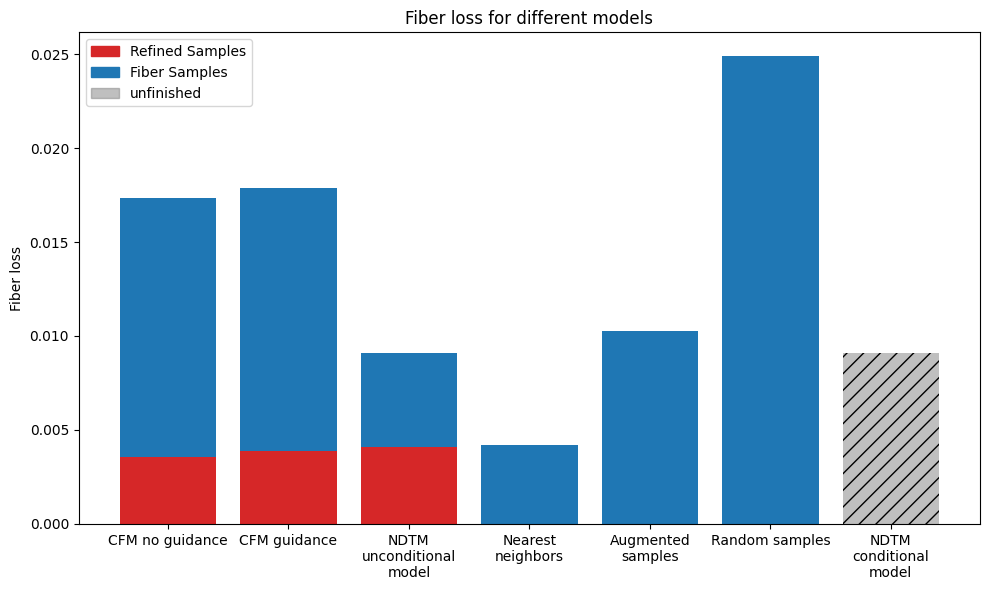

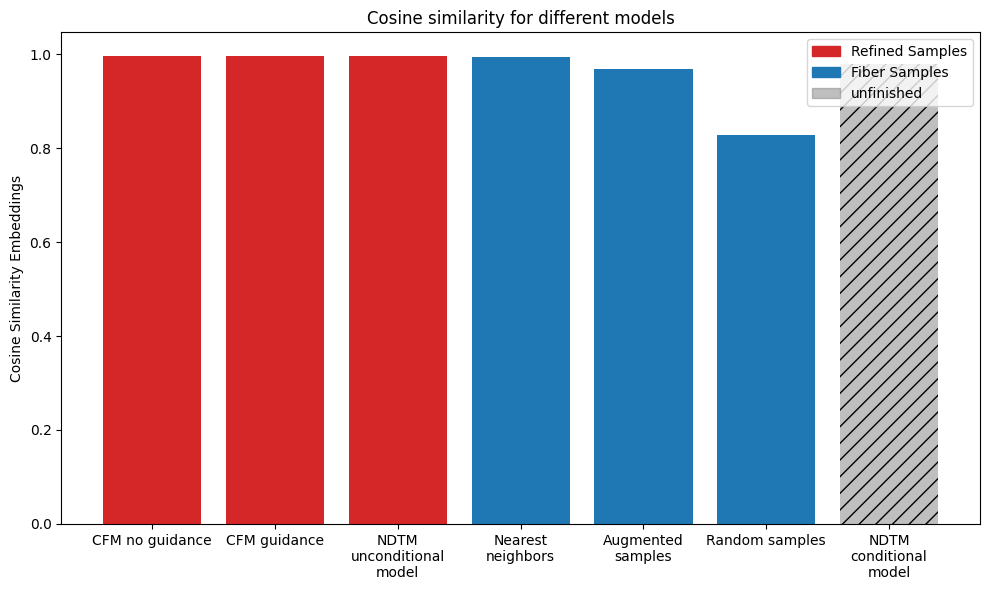

In [38]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))

def wrap_label(label, width=10):
    import textwrap
    return '\n'.join(textwrap.wrap(label, width=width))

for i, (key, value) in enumerate(fiber_losses.items()):
    color = "C0"
    if "refined" in key:
        key = key[:-8]
        color = "C3"
    key = wrap_label(key, width=15)
    plt.bar(key, value, color=color)

plt.bar(wrap_label("NDTM conditional model", width=15), fiber_losses["NDTM unconditional model"], color="gray", label="unfinished", hatch=["//"], alpha=0.5)
    
plt.xticks(ha='center')
plt.ylabel("Fiber loss")
plt.title("Fiber loss for different models")
plt.tight_layout()
red_patch = mpatches.Patch(color='C3', label='Refined Samples')
blue_patch = mpatches.Patch(color='C0', label='Fiber Samples')
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='unfinished')
plt.legend(handles=[red_patch, blue_patch, gray_patch])
plt.show()

plt.figure(figsize=(10, 6))

for i, (key, value) in enumerate(cosine_similarities.items()):
    color = "C0"
    if "refined" in key:
        key = key[:-8]
        color = "C3"
    key = wrap_label(key, width=15)
    plt.bar(key, value, color=color)

plt.bar(wrap_label("NDTM conditional model", width=15), cosine_similarities["NDTM unconditional model"], color="gray", label="unfinished", hatch=["//"], alpha=0.5)
    
plt.xticks(ha='center')
plt.ylabel("Cosine Similarity Embeddings")
plt.title("Cosine similarity for different models")
plt.tight_layout()
red_patch = mpatches.Patch(color='C3', label='Refined Samples')
blue_patch = mpatches.Patch(color='C0', label='Fiber Samples')
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='unfinished')
plt.legend(handles=[red_patch, blue_patch, gray_patch])
plt.show()

Text(0, 1, 'Fiber loss')

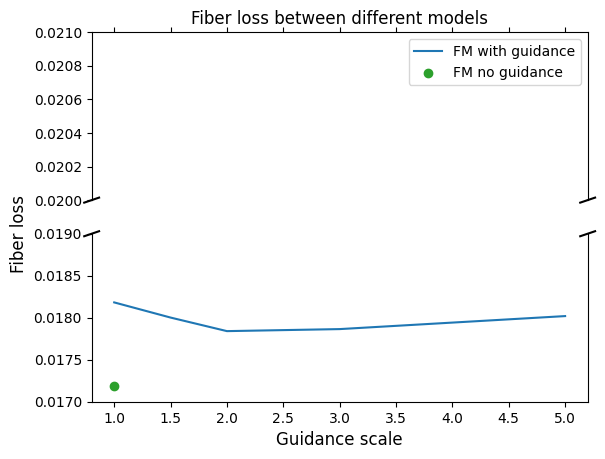

In [35]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.set_ylim(0.02, 0.021)  
ax2.set_ylim(0.0170, 0.0190)  
ax.set_xlim(0.8, 5.2)  
ax2.set_xlim(0.8, 5.2) 
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.plot(scales_fm, torch.stack(fiber_losses_fm, dim=0).cpu().detach().numpy(), label="FM with guidance")
ax2.scatter([1], [fiber_loss_fm_no_guidance.cpu().detach().numpy()], marker="o", color="C2", label="FM no guidance")
#ax.scatter([1], [fiber_loss_fff.cpu().detach().numpy()], marker="x", color="C1", label="FFF")
# Hidden out of plot range, for legend
ax.plot(scales_fm, torch.stack(fiber_losses_fm, dim=0).cpu().detach().numpy(), label="FM with guidance")
ax.scatter([1], [fiber_loss_fm_no_guidance.cpu().detach().numpy()], marker="o", color="C2", label="FM no guidance")
ax.set_title("Fiber loss between different models")
ax.legend()
ax2.set_xlabel("Guidance scale", fontsize=12)
ax2.set_ylabel("Fiber loss", y = 1, fontsize=12)


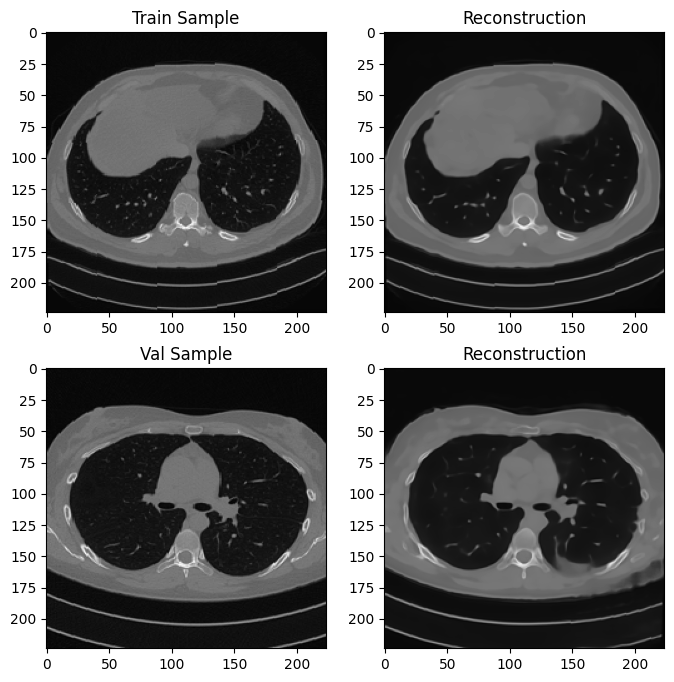

In [36]:
with torch.no_grad():
    batch = model.train_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0_train = conditioned.x0.to(device)
    x_rec_train = model(x0_train, c)
    x_rec_train = x_rec_train.squeeze(0).reshape(1, resolution, resolution)
    batch = model.val_data[0]
    resolution = hparams["data_set"].get("resize_to", 128)
    batch = (batch[0].unsqueeze(0).to(device), batch[1].unsqueeze(0).to(device))
    conditioned = model.apply_conditions(batch)
    c = conditioned.condition.to(device)
    x0_val = conditioned.x0.to(device)
    x_rec_val = model(x0_val, c)
    x_rec_val = x_rec_val.squeeze(0).reshape(1, resolution, resolution)
    plt.figure(figsize=(8,8))
    plt.subplot(2, 2, 1)
    # save color range:
    vmin = x0.min().item()
    vmax = x0.max().item()
    plt.imshow(x0_train.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Train Sample")
    plt.subplot(2, 2, 2)
    plt.imshow(x_rec_train.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Reconstruction")
    plt.subplot(2, 2, 3)
    plt.imshow(x0_val.reshape(resolution, resolution).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Val Sample")
    plt.subplot(2, 2, 4)
    plt.imshow(x_rec_val.squeeze().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.title("Reconstruction")

# Taming Transformers model

In [1]:
from taming.models.vqgan import VQModel, VQNoDiscModel
from omegaconf import OmegaConf
import torch

config_path = "/mnt/SSD_2TB/vqgan_ckpts/imagenet_16384/config.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/armand/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel



In [2]:
model = VQModel(**config.model.params)
ckpt_path = "/mnt/SSD_2TB/vqgan_ckpts/imagenet_16384/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.eval().to(device)
pass

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/armand/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/armand/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/armand/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [3]:
sum(p.numel() for p in model.parameters())/1e6

91.45338

torch.Size([1, 256, 14, 14])
tensor(0.9208, device='cuda:0') tensor(-0.1927, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
torch.Size([1, 3, 224, 224])


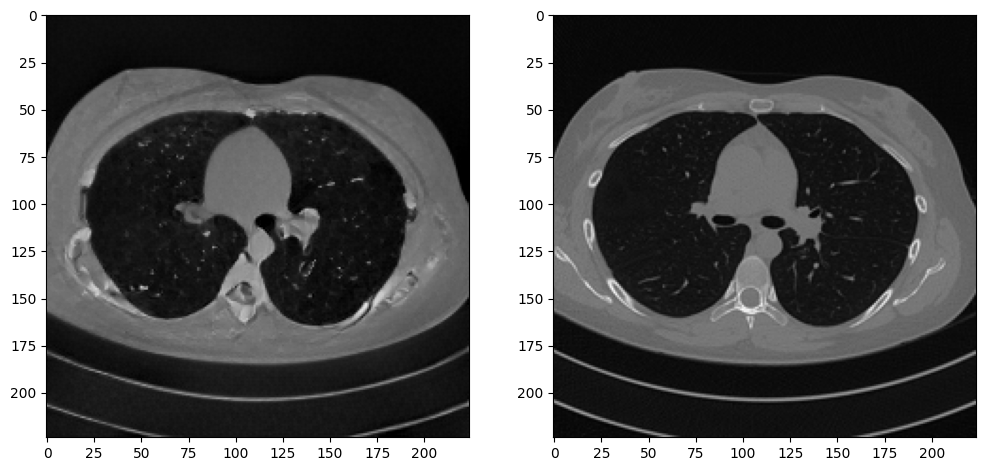

In [8]:
import matplotlib.pyplot as plt
from fff.data import load_dataset

with torch.no_grad():
    
    val_data = load_dataset(
      name="ldct",
      root="/mnt/SSD_2TB/ldct_data",
      condition="lowdose",
      data="highdose",
      patchsize=512,
      resize_to=224,
      subject_model_type="PrecompiledModel",
      subject_model_path="notebooks/SubjectModels/saved_models/BiomedClip.pt",
    )[1]
    input_im = val_data[0][0]
    input_im = input_im.reshape(-1, 1, 224, 224).to(device).repeat(1, 3, 1, 1)
    input_im = (input_im - input_im.min())/(input_im.max() - input_im.min())
    z = model.encode(input_im)[0]
    print(z.shape)
    out = model.decode(z)
    print(out.max(), out.min())
    print(input_im.max(), input_im.min())
    print(out.shape)
    vmin = input_im.min().item()
    vmax = input_im.max().item()
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(out.squeeze().mean(dim=0).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
    plt.subplot(1, 2, 2)
    plt.imshow(input_im.squeeze().mean(dim=0).cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)

# Augmentations

In [1]:
from fff.data import load_dataset
ds = load_dataset(
    name="ldct",
    root="/mnt/SSD_2TB/ldct_data",
    condition="lowdose",
    data="highdose",
    patchsize=512,
    resize_to=224,
    augment=True,
)

INFO: Using pytorch backend
/home/armand/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
train_set = ds[0]

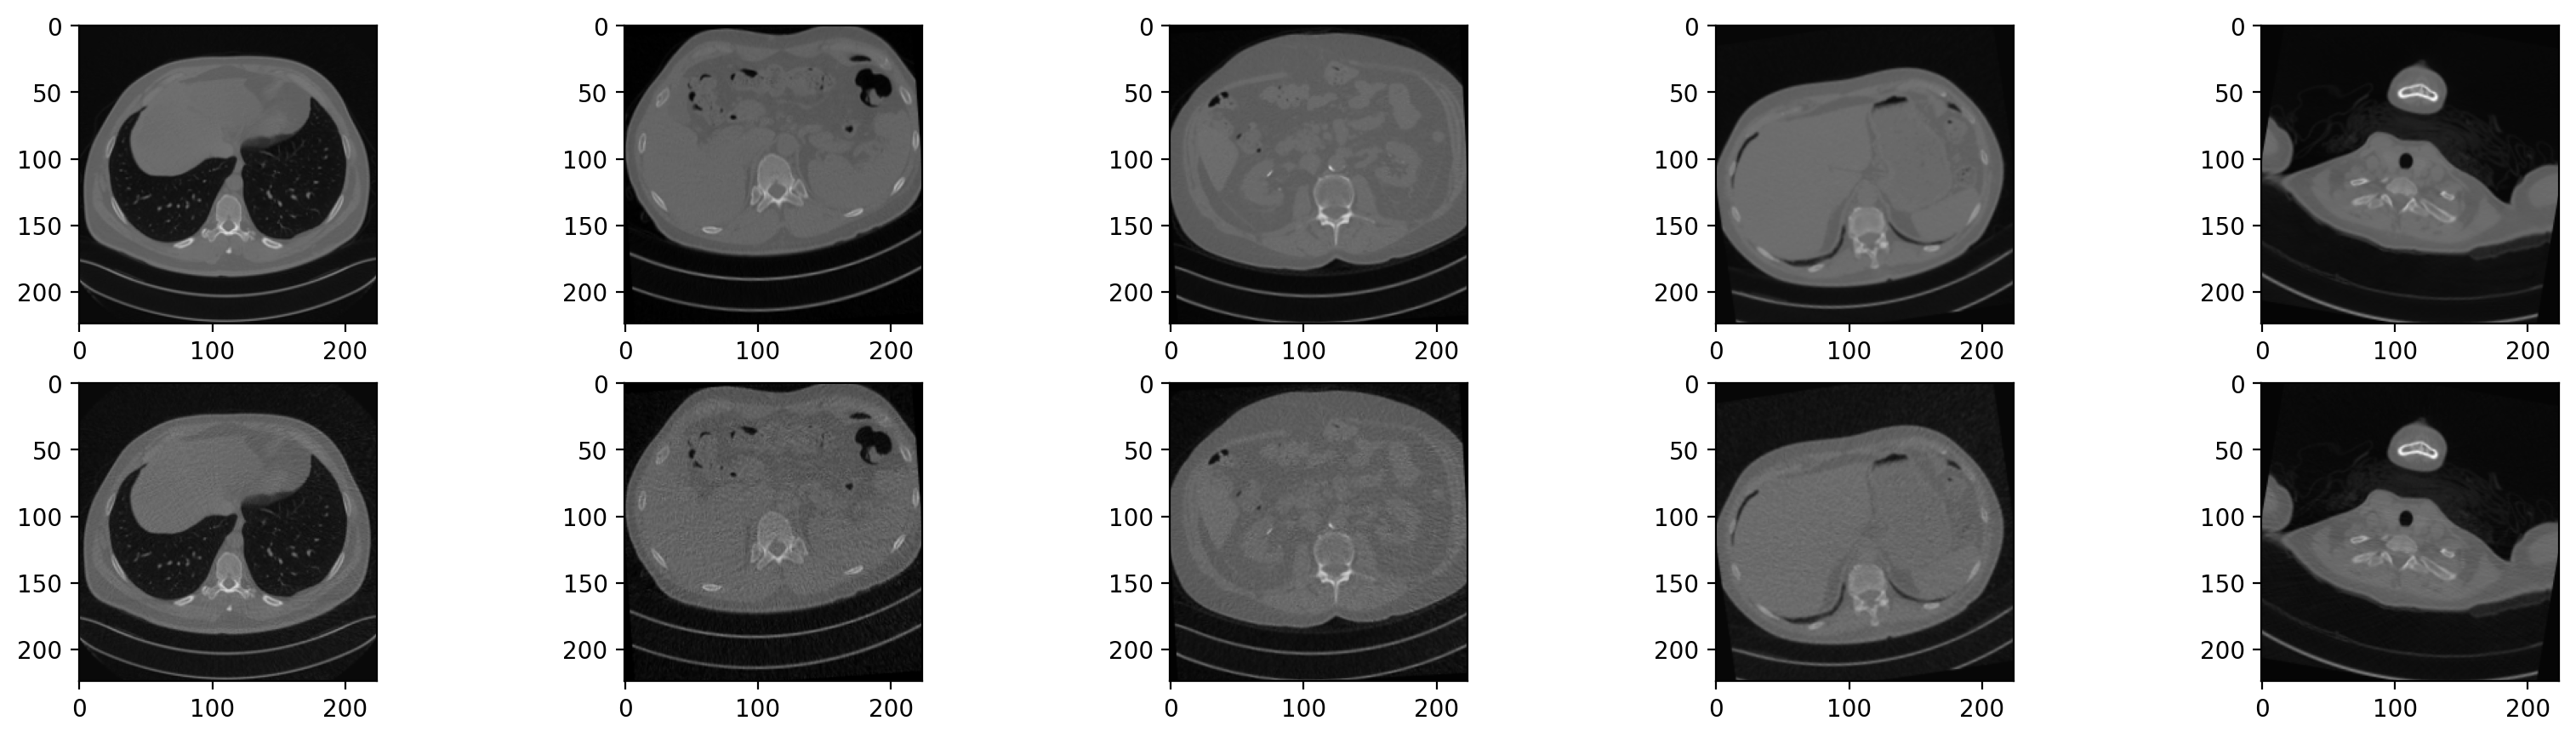

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

batch = [train_set[i] for i in range(5)]
highdose, lowdose = torch.cat([im[0] for im in batch], dim=0), torch.cat([im[1] for im in batch], dim=0)
highdose = highdose.reshape(-1, 1, 224, 224)
lowdose = lowdose.reshape(-1, 1, 224, 224)

plt.figure(figsize=(20, 5), dpi=200)
for i in range(5):
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(highdose[i].permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray", vmin=torch.min(highdose), vmax=torch.max(highdose))
    plt.subplot(2, 5, i + 6)
    plt.imshow(lowdose[i].permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray", vmin=torch.min(lowdose), vmax=torch.max(lowdose))